## Zillow Housing Data Time Series Projections

## Setup

In [179]:
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics

import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
sys.path.insert(0, '../code')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")
%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',25)

from code.functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

# EDA

## Load Data

In [2]:
# load 1 bedroom data
df_1_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

# load 2 bedroom data
df_2_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

In [3]:
# Extract San Franciso
df_1_bd = df_1_bd[df_1_bd.CountyName == 'San Francisco County']
df_2_bd = df_2_bd[df_2_bd.CountyName == 'San Francisco County']

In [4]:
df_1_bd.shape

(25, 311)

In [5]:
print("Shape of 1 Bedroom dataset for San Franciso is ", df_1_bd.shape)
print("Shape of 2 Bedroom dataset for San Franciso is ", df_2_bd.shape)

Shape of 1 Bedroom dataset for San Franciso is  (25, 311)
Shape of 2 Bedroom dataset for San Franciso is  (25, 311)


In [6]:
df_2_bd.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
13,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,395027.0,392274.0,391226.0,388511.0,386522.0,384656.0,383879.0,384905.0,387166.0,389492.0,392773.0,396437.0,401525.0,407460.0,412096.0,416288.0,421565.0,427768.0,433598.0,436851.0,439971.0,443803.0,447826.0,451208.0,454305.0,457637.0,462311.0,468395.0,473483.0,479751.0,485969.0,494312.0,500605.0,507084.0,511696.0,518599.0,524303.0,532287.0,540316.0,547897.0,554617.0,558807.0,563294.0,567268.0,574107.0,582571.0,593726.0,604296.0,613443.0,621085.0,630357.0,644173.0,658651.0,672761.0,684941.0,698422.0,71

In [7]:
df_1_bd.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
12,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,260256.0,259464.0,259741.0,260283.0,261841.0,263092.0,264205.0,265654.0,266982.0,268514.0,269250.0,270052.0,270706.0,272850.0,275068.0,276733.0,277569.0,279036.0,281145.0,282877.0,285615.0,288679.0,293228.0,297098.0,301854.0,306116.0,309977.0,314039.0,317579.0,321445.0,325343.0,329714.0,333798.0,337336.0,340579.0,344750.0,348166.0,351846.0,355766.0,360417.0,365214.0,369852.0,374002.0,378475.0,381427.0,384832.0,389269.0,396378.0,404187.0,412214.0,419917.0,427510.0,435351.0,444464.0,455477.0,466187.0,47

In [8]:
df_1_bd[df_1_bd['1996-01-31'].isna()]

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
7958,97610,8898,94158,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [9]:
df_1_bd[df_1_bd.RegionName==94105]

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
5553,97560,6071,94105,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,303109.0,301177.0,298908.0,295316.0,291498.0,288881.0,284711.0,279925.0,273844.0,270072.0,267909.0,268180.0,268217.0,268745.0,269032.0,269579.0,270684.0,271582.0,274317.0,278746.0,284805.0,289440.0,293456.0,295846.0,299009.0,301329.0,304428.0,307244.0,312091.0,316899.0,322933.0,328228.0,335257.0,341161.0,345477.0,346480.0,348065.0,350254.0,354790.0,357690.0,359060.0,359470.0,362143.0,367605.0,373269.0,377664.0,382422.0,390777.0,399460.0,408193.0,415122.0,422549.0,432263.0,441655.0,450641.0,457706.

In [10]:
df_2_bd[df_2_bd.RegionName==94105]

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
5991,97560,6071,94105,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,NaN,392729.0,393273.0,392154.0,391957.0,391321.0,391315.0,391963.0,393892.0,397352.0,401909.0,404867.0,407667.0,408845.0,411130.0,415580.0,419661.0,424315.0,429898.0,435461.0,440065.0,442835.0,445292.0,451248.0,458114.0,467617.0,473790.0,480375.0,486943.0,497265.0,503818.0,510065.0,515181.0,523155.0,529690.0,536838.0,544364.0,554257.0,567168.0,578472.0,587229.0,590050.0,598841.0,608022.0,620082.0,626726.0,635958.0,642325.0,649039.0,652422.0,660421.0,669955.0,685783.0,698865.0,710743.0,722428.0,737

In [11]:
(df_1_bd.columns == df_2_bd.columns).sum()

311

## Data Exploration

In [12]:
df_1_bd.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
City          0
Metro         0
CountyName    0
1996-01-31    2
1996-02-29    2
1996-03-31    2
1996-04-30    2
1996-05-31    2
1996-06-30    2
1996-07-31    2
1996-08-31    2
1996-09-30    2
1996-10-31    2
1996-11-30    2
1996-12-31    2
1997-01-31    2
1997-02-28    2
1997-03-31    2
1997-04-30    2
1997-05-31    2
1997-06-30    2
1997-07-31    2
1997-08-31    2
1997-09-30    2
1997-10-31    2
1997-11-30    2
1997-12-31    2
1998-01-31    2
1998-02-28    2
1998-03-31    2
1998-04-30    2
1998-05-31    2
1998-06-30    2
1998-07-31    2
1998-08-31    2
1998-09-30    2
1998-10-31    2
1998-11-30    2
1998-12-31    2
1999-01-31    2
1999-02-28    2
1999-03-31    2
1999-04-30    2
1999-05-31    2
1999-06-30    2
1999-07-31    2
1999-08-31    2
1999-09-30    2
1999-10-31    2
1999-11-30    2
1999-12-31    2
2000-01-31    2
2000-02-29    2
2000-03-31    2
2000-04-30    2
2000-05-31    2
2000-06-

In [13]:
df_2_bd.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
City          0
Metro         0
CountyName    0
1996-01-31    3
1996-02-29    2
1996-03-31    2
1996-04-30    2
1996-05-31    2
1996-06-30    2
1996-07-31    2
1996-08-31    2
1996-09-30    2
1996-10-31    2
1996-11-30    2
1996-12-31    2
1997-01-31    2
1997-02-28    2
1997-03-31    2
1997-04-30    2
1997-05-31    2
1997-06-30    2
1997-07-31    2
1997-08-31    2
1997-09-30    2
1997-10-31    2
1997-11-30    2
1997-12-31    2
1998-01-31    2
1998-02-28    2
1998-03-31    2
1998-04-30    2
1998-05-31    2
1998-06-30    2
1998-07-31    2
1998-08-31    2
1998-09-30    2
1998-10-31    2
1998-11-30    2
1998-12-31    2
1999-01-31    2
1999-02-28    2
1999-03-31    2
1999-04-30    2
1999-05-31    2
1999-06-30    2
1999-07-31    2
1999-08-31    2
1999-09-30    2
1999-10-31    2
1999-11-30    2
1999-12-31    2
2000-01-31    2
2000-02-29    2
2000-03-31    2
2000-04-30    2
2000-05-31    2
2000-06-

In [14]:
df_1_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0

In [15]:
df_2_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23

## Reshape DataFrame

In order to run time series analysis, we must reshape our DataFrame from Wide to Long Format.

In [16]:
df_1_melt = melt_data(df_1_bd)
df_2_melt = melt_data(df_2_bd)
columns = ['RegionName', 'date', 'value']
df_1 = df_1_melt[columns]
df_2 = df_2_melt[columns]
df_1.columns = ['zipcode', 'date', 'value']
df_2.columns = ['zipcode', 'date', 'value']

In [17]:
df_1.zipcode.value_counts()

94105    302
94111    302
94134    302
94122    302
94118    302
94114    302
94110    302
94102    302
94131    302
94127    302
94123    302
94115    302
94107    302
94109    302
94103    302
94132    302
94124    302
94116    302
94112    302
94108    302
94133    302
94121    302
94117    302
94104    231
94158    158
Name: zipcode, dtype: int64

In [18]:
df_2.zipcode.value_counts()

94107    302
94122    302
94114    302
94110    302
94102    302
94131    302
94127    302
94123    302
94115    302
94111    302
94109    302
94103    302
94132    302
94124    302
94116    302
94112    302
94108    302
94134    302
94133    302
94121    302
94117    302
94118    302
94105    301
94158    194
94104    176
Name: zipcode, dtype: int64

In [19]:
(set(df_1.zipcode) - set(df_2.zipcode))

set()

In [20]:
df_2

,zipcode,date,value
0,94109,1996-01-31,395027.0
1,94110,1996-01-31,244323.0
2,94122,1996-01-31,270792.0
3,94112,1996-01-31,226713.0
4,94115,1996-01-31,304296.0
...,...,...,...
7545,94127,2021-02-28,1488832.0
7546,94108,2021-02-28,1502923.0
7547,94158,2021-02-28,1513017.0
7548,94111,2021-02-28,1466530.0


Create separate DataFrames for 1-bedroom homes and 2-bedroom homes averaged across zip codes.

In [21]:
sf_1_all = df_1.groupby('date').aggregate({'value':'mean'})
sf_2_all = df_2.groupby('date').aggregate({'value':'mean'})

In [ ]:
sf_1_all

## Visualization

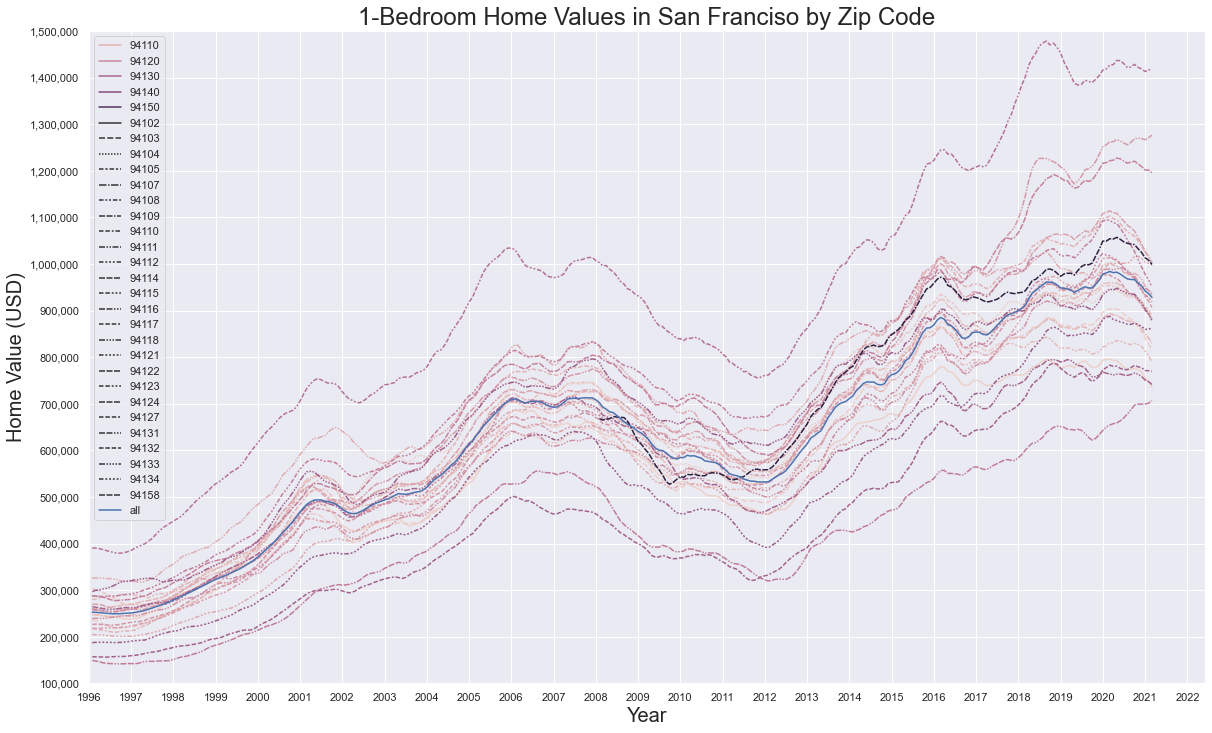

In [47]:
# sns.set_palette('cubehelix', 1) 
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('1-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_1, x=df_1.date, y=df_1.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_1_all, x=sf_1_all.index, y=sf_1_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.set_yticks(np.linspace(1e5,1.5e6,15))
ax.set_ylim((1e5, 1.5e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/1_bdrm_home_values.png')

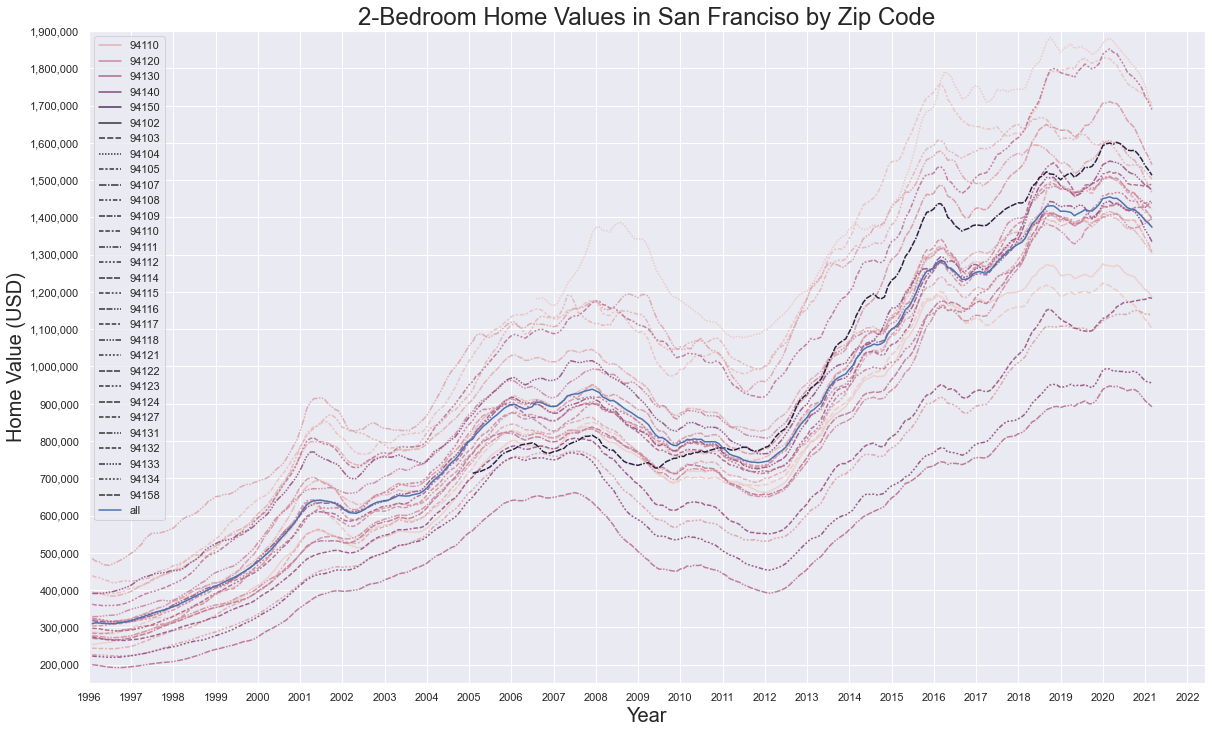

In [48]:
# sns.set_palette('cubehelix', 1) 
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('2-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_2, x=df_2.date, y=df_2.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_2_all, x=sf_2_all.index, y=sf_2_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.set_yticks(np.linspace(2e5,1.9e6,18))
ax.set_ylim((1.5e5, 1.9e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/2_bdrm_home_values.png')

# Data Prep

In [ ]:
# Pad two Zip Codes with NaNs
# df_1 = df_1.append({'zipcode': '94104', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
# df_1 = df_1.append({'zipcode': '94158', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
# df_2 = df_2.append({'zipcode': '94104', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
# df_2 = df_2.append({'zipcode': '94158', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
# df_2 = df_2.append({'zipcode': '94105', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)

In [ ]:
# df_1.append({'zipcode': '94104', 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)

In [ ]:
df_1.isna().sum()

In [ ]:
df_1[df_1.zipcode==94104]

## Prepare Data Structure

In [22]:
zipcodes_1

NameError: name 'zipcodes_1' is not defined

In [32]:
zipcodes_1 = list(set(df_1.zipcode))
zipcodes_2 = list(set(df_2.zipcode))
keys_1 = [zipcode for zipcode in map(str,zipcodes_1)]
keys_2 = [zipcode for zipcode in map(str,zipcodes_2)]
sf_1_list = []
sf_2_list = []

# for zipcode in zipcodes:
for key in keys_1: 
#     print(key)
#     sf_1_list.append(df_1[df_1.zipcode == zipcode])
    new_pd = df_1[df_1.zipcode == int(key)]
    if len(new_pd) < 302:
        print('padding', key, len(new_pd))
        new_pd.append({'zipcode': int(key), 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
        sf_1_list.append(new_pd)
        print(len(new_pd))
        print(new_pd.isna().sum())
#         print(sf_1_list[-1])
    else: 
        sf_1_list.append(new_pd)
#     print(len(df_1[df_1.zipcode == zipcode]))
    sf_1_list[-1].drop('zipcode', inplace=True, axis=1)
    sf_1_list[-1].columns = ['date', 'value']
    sf_1_list[-1].date = pd.to_datetime(sf_1_list[-1].date)
    sf_1_list[-1].set_index('date', inplace=True)
    sf_1_list[-1] = sf_1_list[-1].asfreq('M')

for key in keys_2: 
#     print(key)
#     sf_2_list.append(df_2[df_2.zipcode == zipcode])
    new_pd_2 = df_2[df_2.zipcode == int(key)]

    if len(new_pd_2) < 302:
        print('padding', key, len(new_pd_2))
        new_pd_2.append({'zipcode': int(key), 'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
    sf_2_list.append(new_pd_2)
    sf_2_list[-1].drop('zipcode', inplace=True, axis=1)
    sf_2_list[-1].columns = ['date', 'value']
    sf_2_list[-1].date = pd.to_datetime(sf_2_list[-1].date)
    sf_2_list[-1].set_index('date', inplace=True)
    sf_2_list[-1] = sf_2_list[-1].asfreq('M')

# sf_1_dict = dict(zip(keys, sf_1_list))
# sf_2_dict = dict(zip(keys, sf_2_list))
sf_1_dict = dict(zip(keys_1, sf_1_list))
sf_2_dict = dict(zip(keys_2, sf_2_list))

padding 94104 231
231
zipcode    0
date       0
value      0
dtype: int64
padding 94158 158
158
zipcode    0
date       0
value      0
dtype: int64
padding 94104 176
padding 94105 301
padding 94158 194


94105    231 (only an issue with 2-bed)  
94158    158  
94104    176

In [27]:
sf_1_dict['94104'].isna().sum()

value    0
dtype: int64

In [ ]:
# sf_1_dict['94104'] = sf_1_dict['94104'].append({'date': '1996-01-31', 'value': np.NaN}, ignore_index=True)
# sf_1_dict['94104']

## Test Stationarity

In [ ]:
for k, v in sf_1_dict.items():
#     if k=='94105':
    print(k,len(v))
#     print(v)

In [ ]:
for k, v in sf_2_dict.items():
    if k=='94105':
        print(k,len(v))
        print(v)
# for k, v in sf_2_dict.items():
#     print(k,len(v))

### 1-Bedroom Home Values

In [33]:
# Undifferenced data
dftest = adfuller(sf_1_all)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -1.793011
p-value                          0.383937
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [34]:
# Differenced data
dftest = adfuller(sf_1_all.diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -2.316876
p-value                          0.166583
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [35]:
# Twice-Differenced data
dftest = adfuller(sf_1_all.diff().diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                -7.097080e+00
p-value                        4.261762e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


### 2-Bedroom Home Values

In [36]:
# Undifferenced data
dftest = adfuller(sf_2_all)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -1.400165
p-value                          0.582197
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [37]:
# Once-Differenced data
dftest = adfuller(sf_2_all.diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                  -2.425809
p-value                          0.134584
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


In [38]:
# Twice-Differenced data
dftest = adfuller(sf_2_all.diff().diff().dropna())
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' %key] = value
print (dfoutput)

Test Statistic                -6.661065e+00
p-value                        4.845806e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


In [39]:
for zipcode, df in sf_1_dict.items():
    dftest = adfuller(df.diff().dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput[1])

0.1926145455165832
0.2060422729459903
0.28775511977713875
0.07993566297172833
0.12863966926350828
0.09891970954011631
0.08290320249362182
0.3111836117777681
0.13715105283198115
0.14637328895676732
0.17271856642597144
0.1337574409333543
0.06464975186815168
0.09976068994950421
0.07803295357584289
0.3662963961134048
0.10228118941553666
0.28197131317300095
0.08767823497608018
0.07952584152580128
0.17592392816866875
0.16263008723813865
0.04817661237234456
0.2480195401331708
0.09750369141922782


In [40]:
for zipcode, df in sf_2_dict.items():
    dftest = adfuller(df.diff().dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                         'p-value', '#Lags Used',
                                         'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput[1])

0.2229988866563588
0.20341818104256465
0.24390284407782337
0.030833635274431278
0.12383926158723568
0.07283425733482167
0.19879946976070362
0.11240533490243582
0.08577133012198046
0.16711867703126432
0.2127939064194314
0.16509636409843742
0.05097122573040681
0.15619218111390498
0.07190436345815086
0.25625231439948004
0.029105514316216642
0.2677355065731407
0.1442688188097958
0.02175184603117924
0.09244256234062642
0.031485249237360576
0.12534484435935578
0.17940667945630767
0.5028144750781229


## Plot ACF and PACF

### 1-Bedroom Home Values

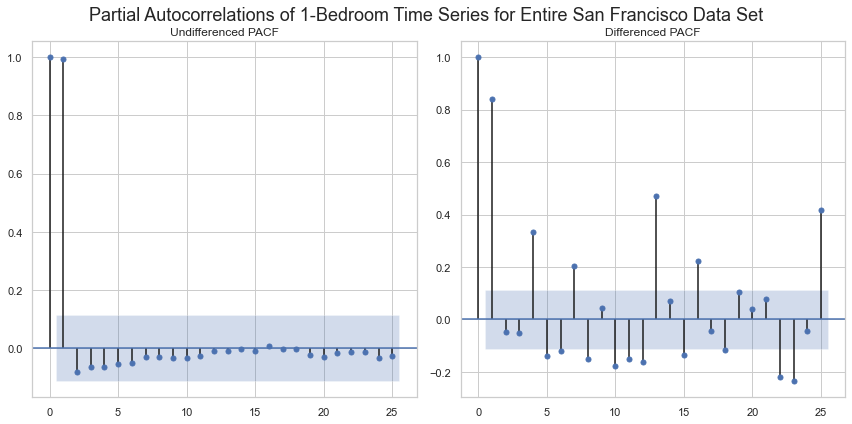

In [41]:
pacf_1_fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pacf_1_fig.suptitle('Partial Autocorrelations of 1-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_pacf(sf_1_all, ax=ax[0])
ax[0].set_title('Undifferenced PACF')
plot_pacf(sf_1_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Differenced PACF')
pacf_1_fig.tight_layout()
pacf_1_fig.subplots_adjust(top=0.9)
plt.savefig('images/1_bdrm_PACF.png')

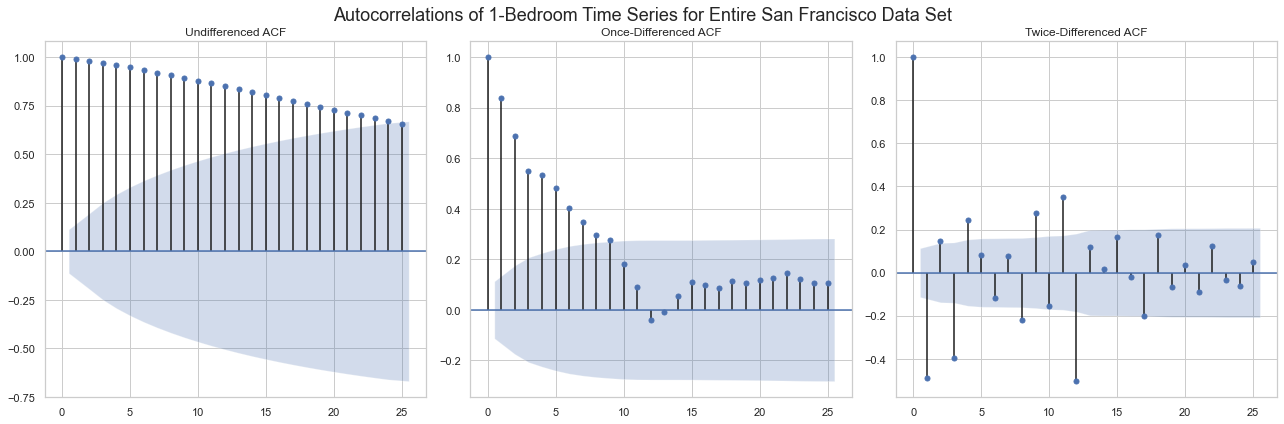

In [42]:
acf_1_fig, ax = plt.subplots(1, 3, figsize=(18, 6))
acf_1_fig.suptitle('Autocorrelations of 1-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_acf(sf_1_all, ax=ax[0])
ax[0].set_title('Undifferenced ACF')
plot_acf(sf_1_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Once-Differenced ACF')
plot_acf(sf_1_all.diff().diff().diff().dropna(), ax=ax[2])
ax[2].set_title('Twice-Differenced ACF')
acf_1_fig.tight_layout()
acf_1_fig.subplots_adjust(top=0.9)
plt.savefig('images/1_bdrm_ACF.png')

### 2-Bedroom Home Values

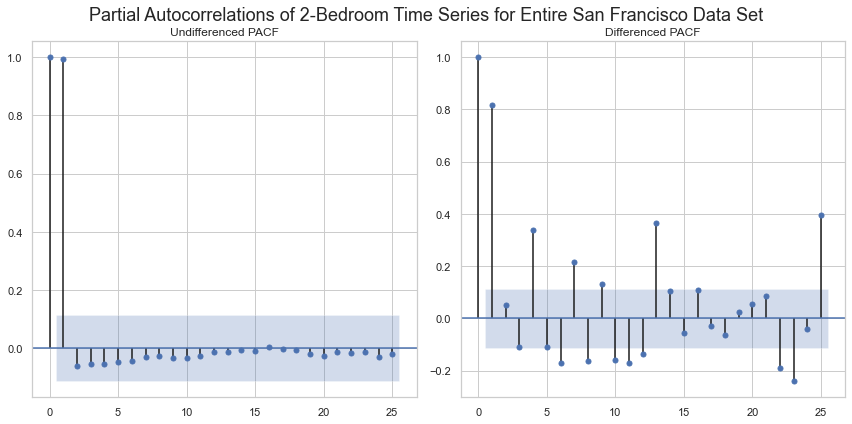

In [43]:
pacf_2_fig, ax = plt.subplots(1, 2, figsize=(12, 6))
pacf_2_fig.suptitle('Partial Autocorrelations of 2-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_pacf(sf_2_all, ax=ax[0])
ax[0].set_title('Undifferenced PACF')
plot_pacf(sf_2_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Differenced PACF')
pacf_2_fig.tight_layout()
pacf_2_fig.subplots_adjust(top=0.9)
plt.savefig('images/2_bdrm_PACF.png')

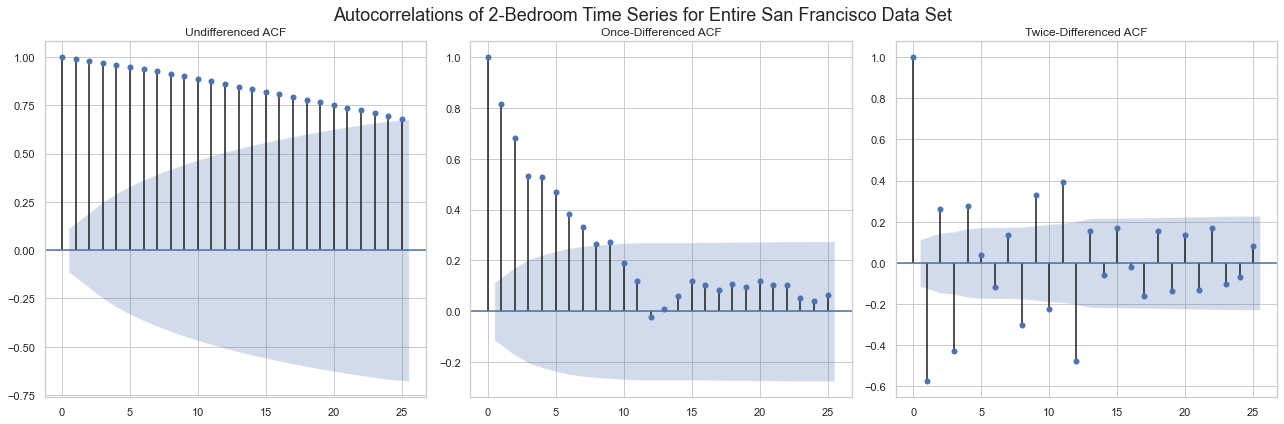

In [44]:
acf_2_fig, ax = plt.subplots(1, 3, figsize=(18, 6))
acf_2_fig.suptitle('Autocorrelations of 2-Bedroom Time Series for Entire San Francisco Data Set', fontsize=18)
plot_acf(sf_2_all, ax=ax[0])
ax[0].set_title('Undifferenced ACF')
plot_acf(sf_2_all.diff().dropna(), ax=ax[1])
ax[1].set_title('Once-Differenced ACF')
plot_acf(sf_2_all.diff().diff().diff().dropna(), ax=ax[2])
ax[2].set_title('Twice-Differenced ACF')
acf_2_fig.tight_layout()
acf_2_fig.subplots_adjust(top=0.9)
plt.savefig('images/2_bdrm_ACF.png')

## Plot Seasonal Decomposition

### 1-Bedroom Home Values

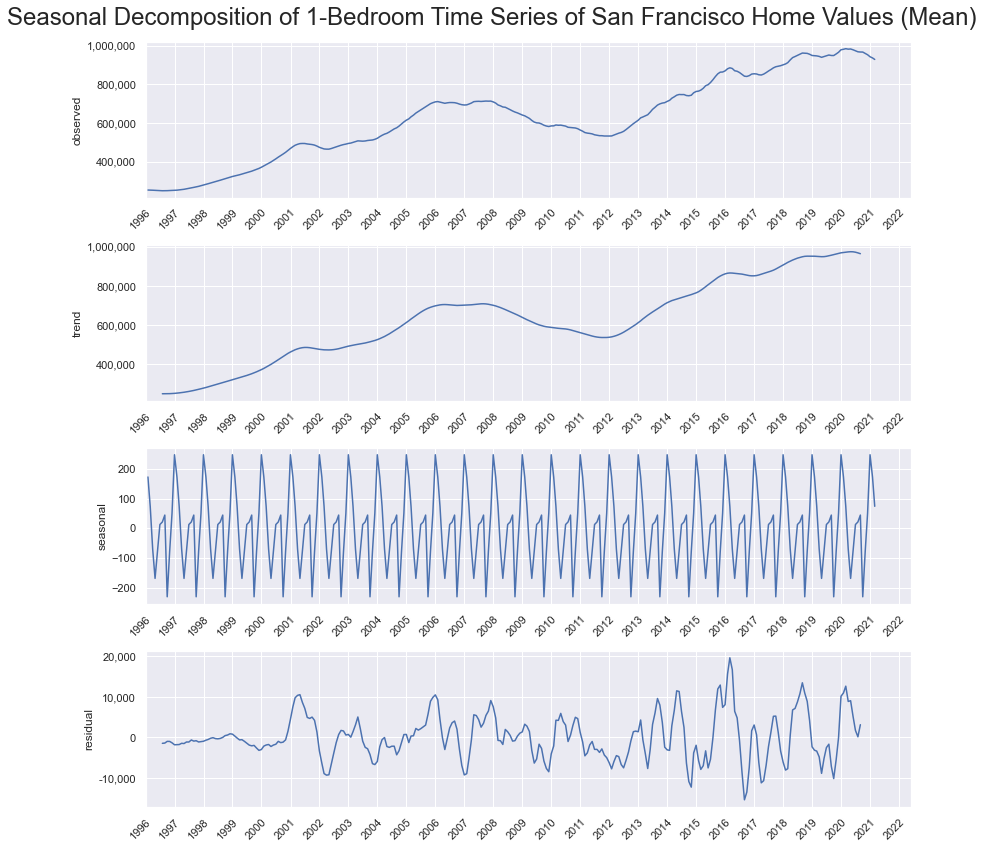

In [49]:
decomp_1 = seasonal_decompose(sf_1_all, freq=12)
dc_1_obs = decomp_1.observed
dc_1_trend = decomp_1.trend
dc_1_seas = decomp_1.seasonal
dc_1_resid = decomp_1.resid
dc_1_df = pd.DataFrame({"observed": dc_1_obs, "trend": dc_1_trend,
                        "seasonal": dc_1_seas, "residual": dc_1_resid})
decomp_1_fig, axes = plt.subplots(4, 1, figsize=(12, 12))

for i, ax in enumerate(axes):
    ax.plot(dc_1_df.iloc[:, i])
    ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(dc_1_df.iloc[:, i].name)
    if i != 2:
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    
decomp_1_fig.suptitle(
    'Seasonal Decomposition of 1-Bedroom Time Series of San Francisco Home Values (Mean)', fontsize=24)
decomp_1_fig.tight_layout()
decomp_1_fig.subplots_adjust(top=0.94)
plt.savefig('images/1_bdrm_seasonal_decomp.png')

### 2-Bedroom Home Values

In [63]:
dc_2_df

,observed,trend,seasonal,residual
date,,,,
1996-01-31,252714.043478,NaN,172.510334,NaN
1996-02-29,252364.478261,NaN,73.955301,NaN
1996-03-31,251782.391304,NaN,-69.822184,NaN
1996-04-30,251039.652174,NaN,-168.396577,NaN
1996-05-31,250138.260870,NaN,-76.994551,NaN
1996-06-30,249686.086957,NaN,12.688323,NaN
1996-07-31,249109.434783,250553.670290,21.359942,-1465.595449
1996-08-31,249207.956522,250565.509058,44.480557,-1402.033093
1996-09-30,249520.565217,250739.360507,-230.201589,-988.593701


In [75]:
end = dc_2_df.iloc[:, 0].index[-1] + relativedelta(months=+15) + relativedelta(day=31)
end

Timestamp('2022-05-31 00:00:00')

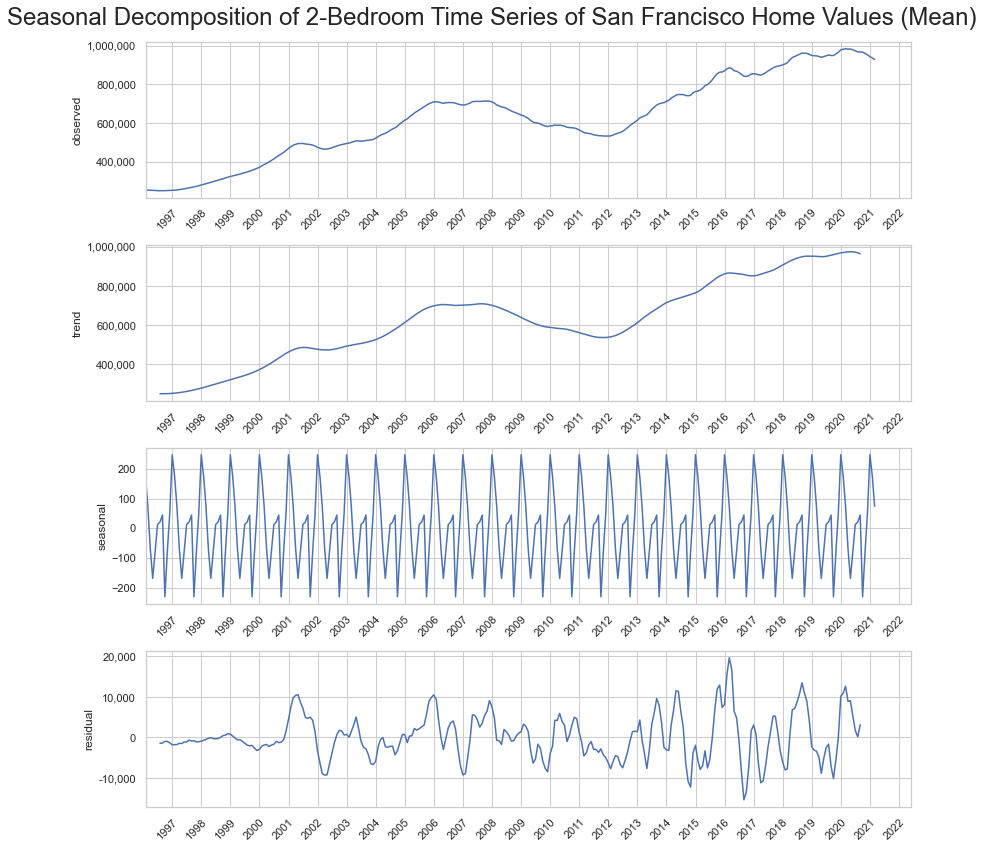

In [76]:
decomp_2 = seasonal_decompose(sf_2_all, freq=12)
dc_2_obs = decomp_1.observed
dc_2_trend = decomp_1.trend
dc_2_seas = decomp_1.seasonal
dc_2_resid = decomp_1.resid
dc_2_df = pd.DataFrame({"observed": dc_2_obs, "trend": dc_2_trend,
                        "seasonal": dc_2_seas, "residual": dc_2_resid})
decomp_2_fig, axes = plt.subplots(4, 1, figsize=(12, 12))

start = dc_2_df.iloc[:, 0].index[0]
end = dc_2_df.iloc[:, 0].index[-1] + relativedelta(months=+15) + relativedelta(day=31)
for i, ax in enumerate(axes):
    ax.plot(dc_2_df.iloc[:, i])
#     ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
    ax.set_xlim(start, end)
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_ylabel(dc_2_df.iloc[:, i].name)
    if i != 2:
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    
decomp_2_fig.suptitle(
    'Seasonal Decomposition of 2-Bedroom Time Series of San Francisco Home Values (Mean)', fontsize=24)
decomp_2_fig.tight_layout()
decomp_2_fig.subplots_adjust(top=0.94)
plt.savefig('images/2_bdrm_seasonal_decomp.png')

# ARIMA Modeling

## Perform Train-Test Split

In [183]:
def train_test_split_housing(data_dict):
    cutoff = [round(0.8*len(df)) for zipcode, df in data_dict.items()]
    train_dict_list = [data_dict[i][:cutoff[count]] for count, i in enumerate(list(data_dict.keys()))]
    train_dict = dict(zip(list(data_dict.keys()), train_dict_list))
    test_dict_list = [data_dict[i][cutoff[count]:] for count, i in enumerate(list(data_dict.keys()))]
    test_dict = dict(zip(list(data_dict.keys()), test_dict_list))
    return train_dict, test_dict

In [184]:
sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict)
sf_2_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict)

In [144]:
# cutoff = round(len(sf_1_dict[list(sf_1_dict.keys())[0]])*.8)

# cutoff_1 = [round(0.8*len(df)) for zipcode, df in sf_1_dict.items()]
# cutoff_2 = [round(0.8*len(df)) for zipcode, df in sf_2_dict.items()]

# # sf_1_train_dict_list = [sf_1_dict[i][:cutoff] for i in list(sf_1_dict.keys())]
# sf_1_train_dict_list = [sf_1_dict[i][:cutoff_1[count]] for count, i in enumerate(list(sf_1_dict.keys()))]
# sf_1_train_dict = dict(zip(list(sf_1_dict.keys()), sf_1_train_dict_list))

# # sf_2_train_dict_list = [sf_2_dict[i][:cutoff] for i in list(sf_2_dict.keys())]
# sf_2_train_dict_list = [sf_2_dict[i][:cutoff_2[count]] for count, i in enumerate(list(sf_2_dict.keys()))]
# sf_2_train_dict = dict(zip(list(sf_2_dict.keys()), sf_2_train_dict_list))

# sf_1_test_dict_list = [sf_1_dict[i][cutoff_1[count]:] for count, i in enumerate(list(sf_1_dict.keys()))]
# sf_1_test_dict = dict(zip(list(sf_1_dict.keys()), sf_1_test_dict_list))

# sf_2_test_dict_list = [sf_2_dict[i][cutoff_2[count]:] for count, i in enumerate(list(sf_2_dict.keys()))]
# sf_2_test_dict = dict(zip(list(sf_2_dict.keys()), sf_2_test_dict_list))

## Manual GridSearch of Model Parameters

In [ ]:
# p = range(2, 3)
# q = range(1, 3)
# s_p = range(2, 3)
# s_q = range(1, 3)
# pdq = list(itertools.product(p, [1], q))
# # seasonal_pdq = list(itertools.product(s_p, [1], s_q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(s_p, [1], s_q))]
# print('Examples of parameter for SARIMA...')
# for i in pdq:
#     for s in seasonal_pdq:
#         print('SARIMAX: {} x {}'.format(i, s))

In [ ]:
# # auto_arima(sf_1_all,seasonal=True,m=12).summary()
# auto_arima(sf_1_train_dict['1_bdrm_97557'],seasonal=True,m=12).summary()


In [53]:
def gridsearch_SARIMAX(train_dict, seas = 12, p_min=2, p_max=2, q_min=1, q_max=2, d_min=1, d_max=2,
                       s_p_min=2, s_p_max=2, s_q_min=1, s_q_max=2, s_d_min=1, s_d_max=2):
    p = range(p_min, p_max+1)
    q = range(q_min, q_max+1)
    d = range(d_min, d_max+1)
    s_p = range(s_p_min, s_p_max+1)
    s_q = range(s_q_min, s_q_max+1)
    s_d = range(s_d_min, s_d_max+1)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], seas) for x in list(itertools.product(s_p, s_d, s_q))]
    print('Parameters for SARIMAX grid search...')
    for i in pdq:
        for s in seasonal_pdq:
            print('SARIMAX: {} x {}'.format(i, s))
    
    zipcodes = []
    param_list = []
    param_seasonal_list = []
    aic_list = []

    for zipcode, train in train_dict.items():
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                mod = SARIMAX(train,
                              order=param,
                              seasonal_order=param_seasonal,
                              enforce_stationarity=False,
                              enforce_invertibility=False)
                zipcodes.append(zipcode[-5:])
                param_list.append(param)
                param_seasonal_list.append(param_seasonal)
                aic = mod.fit().aic
                aic_list.append(aic)
                print(aic)
    return zipcodes, param_list, param_seasonal_list, aic_list

In [ ]:
# zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict)
# zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_1_train_dict)

In [147]:
zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict, 12, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2)
zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_2_train_dict, 12, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2)

Parameter for SARIMAX grid search...
SARIMAX: (2, 1, 0) x (2, 1, 0, 12)
3941.707855478236
3851.6305931087823
2930.09153682129
3908.755177191617
3869.816229204637
3945.3360309734085
3921.7790002488746
3967.330212017774
4042.2366806539876
3918.7442623505112
3979.208116314895
3945.950431732758
3929.5009446510144
3950.736062207258
3948.048917222933
3973.846124068667
3938.6111506148736
3936.541586019538
3823.519686962368
4065.6711173670374
3917.875335761565
3772.847724644099
3950.748473555761
3834.910204529915
1726.3553997196302
Parameter for SARIMAX grid search...
SARIMAX: (2, 1, 0) x (2, 1, 0, 12)
3998.759298957303
3948.3838937874743
2190.0920295862798
4161.344855473899
4007.670405072841
4241.58870218677
4069.5907651662906
3983.7296508536724
4187.23930261828
3889.5072862150755
4102.2204434962905
4070.684183586345
3904.3425621734273
4100.4325241554125
4093.969191306772
3996.6358965502936
3959.4908237074724
4157.412000957335
3790.410256683276
3967.1901380209742
4069.755463569883
3979.677761

In [ ]:
# # 1-Bedroom Homes
# for zipcode, train in sf_1_train_dict.items():
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             mod = SARIMAX(train,
#                           order=param,
#                           seasonal_order=param_seasonal,
#                           enforce_stationarity=False,
#                           enforce_invertibility=False)
#             zipcodes_1.append(zipcode[-5:])
#             param_1_list.append(param)
#             param_1_seasonal_list.append(param_seasonal)
#             aic_1_list.append(mod.fit().aic)
#             print(aic_1_list[-1])
       

In [ ]:
# # 2-Bedroom Homes
# for zipcode, train in sf_2_train_dict.items():
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             mod = SARIMAX(train,
#                           order=param,
#                           seasonal_order=param_seasonal,
#                           enforce_stationarity=False,
#                           enforce_invertibility=False)
#             zipcodes_2.append(zipcode[-5:])
#             param_2_list.append(param)
#             param_2_seasonal_list.append(param_seasonal)
#             aic_2_list.append(mod.fit().aic)
#             print(aic_2_list[-1])

In [ ]:
# # intialise data of lists
# model_data_1 = {'zipcodes': zipcodes_1,
#         'param': param_1_list,
#         'param_seasonal': param_1_seasonal_list,
#         'aic': aic_1_list}

# model_data_2 = {'zipcodes': zipcodes_2,
#         'param': param_2_list,
#         'param_seasonal': param_2_seasonal_list,
#         'aic': aic_2_list}

# # Create DataFrames
# sarimax_1_details_df = pd.DataFrame(model_data_1)
# sarimax_2_details_df = pd.DataFrame(model_data_2)
# print(sarimax_1_details_df.shape, sarimax_2_details_df.shape)

In [ ]:
# sf_1_best_df = sarimax_1_details_df.loc[sarimax_1_details_df.groupby("zipcodes")["aic"].idxmin()]
# sf_1_best_df.set_index('zipcodes', inplace = True)
# print(sf_1_best_df)
# print()
# sf_2_best_df = sarimax_2_details_df.loc[sarimax_2_details_df.groupby("zipcodes")["aic"].idxmin()]
# sf_2_best_df.set_index('zipcodes', inplace = True)
# print(sf_2_best_df)

In [56]:
def get_best_params(zipcodes, param_list, param_seasonal_list, aic_list, bedrooms):
    # intialize list of model params
    model_data = {'zipcode': zipcodes,
                  'param': param_list,
                  'param_seasonal': param_seasonal_list,
                  'aic': aic_list
                  }
    # Create model params DataFrames
    sarimax_details_df = pd.DataFrame(model_data)
#     print(sarimax_details_df.shape)

    best_params_df = sarimax_details_df.loc[sarimax_details_df.groupby('zipcode')['aic'].idxmin()]
    best_params_df.set_index('zipcode', inplace=True)
    print(best_params_df)
    best_params_df.to_csv(f'data/{bedrooms}_bdrm_best_params.csv')
    return best_params_df

In [148]:
sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)

             param param_seasonal          aic
zipcode                                       
94102    (2, 1, 0)  (2, 1, 0, 12)  3941.707855
94103    (2, 1, 0)  (2, 1, 0, 12)  3851.630593
94104    (2, 1, 0)  (2, 1, 0, 12)  2930.091537
94105    (2, 1, 0)  (2, 1, 0, 12)  3908.755177
94107    (2, 1, 0)  (2, 1, 0, 12)  3869.816229
94108    (2, 1, 0)  (2, 1, 0, 12)  3945.336031
94109    (2, 1, 0)  (2, 1, 0, 12)  3921.779000
94110    (2, 1, 0)  (2, 1, 0, 12)  3967.330212
94111    (2, 1, 0)  (2, 1, 0, 12)  4042.236681
94112    (2, 1, 0)  (2, 1, 0, 12)  3918.744262
94114    (2, 1, 0)  (2, 1, 0, 12)  3979.208116
94115    (2, 1, 0)  (2, 1, 0, 12)  3945.950432
94116    (2, 1, 0)  (2, 1, 0, 12)  3929.500945
94117    (2, 1, 0)  (2, 1, 0, 12)  3950.736062
94118    (2, 1, 0)  (2, 1, 0, 12)  3948.048917
94121    (2, 1, 0)  (2, 1, 0, 12)  3973.846124
94122    (2, 1, 0)  (2, 1, 0, 12)  3938.611151
94123    (2, 1, 0)  (2, 1, 0, 12)  3936.541586
94124    (2, 1, 0)  (2, 1, 0, 12)  3823.519687
94127    (2, 

## Evaluate Model

In [58]:
def evaluate_model(train_dict, test_dict, model_best_df):
    predict_dict = {}
    cat_predict_dict = train_dict.copy()
    for _ in range(5):
        for zipcode, df in cat_predict_dict.items():
            if cat_predict_dict[zipcode].index[-1] >= pd.to_datetime('2021-02-28'):
                continue
            sari_mod = SARIMAX(df,
                               order=model_best_df.loc[zipcode].param,
                               seasonal_order=model_best_df.loc[zipcode].param_seasonal,
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit()

            predict = sari_mod.forecast(steps = 12, dynamic = False)    
            print((zipcode,predict.index[-1],predict[-1]))
            predict_dict[zipcode] = predict
            dfB = pd.DataFrame(predict_dict[zipcode])
            dfB.columns = ['value']
            dfA = cat_predict_dict[zipcode]
            cat_predict_dict[zipcode] = pd.concat([dfA, dfB], axis=0)
    return cat_predict_dict

In [141]:
def calc_RMSE(test_dict, predictions_dict):
    zipcodes = []
    RMSE_list = []
    hv = []
    for zipcode, df in test_dict.items():
        window = len(df)
        RMSE = metrics.mean_squared_error(test_dict[zipcode], predictions_dict[zipcode].iloc[-window:], squared=False)
        zipcodes.append(zipcode)
        RMSE_list.append(RMSE)
        
    # get last observed house value per zip code
    for zipcode, df in sf_1_dict.items():
        hv.append(df.iloc[-1].value)
    RMSE_data = {'zipcode': zipcodes,
                 'RMSE': RMSE_list,
                 'last_value': hv
                 }
    RMSE_df = pd.DataFrame(RMSE_data)
    RMSE_df = RMSE_df.sort_values('RMSE', axis=0, ascending=False)
    RMSE_df['RMSE_vs_value'] = 100*RMSE_df.RMSE/RMSE_df.last_value
    RMSE_df.set_index('zipcode', inplace=True)
    return RMSE_df

In [149]:
sf_1_pred_dict = evaluate_model(sf_1_train_dict, sf_1_test_dict, sf_1_best_df)
sf_2_pred_dict = evaluate_model(sf_2_train_dict, sf_2_test_dict, sf_2_best_df)

('94102', Timestamp('2017-02-28 00:00:00', freq='M'), 816928.7410542257)
('94103', Timestamp('2017-02-28 00:00:00', freq='M'), 916202.6873506621)
('94104', Timestamp('2018-04-30 00:00:00', freq='M'), 894980.3110996869)
('94105', Timestamp('2017-02-28 00:00:00', freq='M'), 996505.542899767)
('94107', Timestamp('2017-02-28 00:00:00', freq='M'), 968696.4328816485)
('94108', Timestamp('2017-02-28 00:00:00', freq='M'), 871038.2506276343)
('94109', Timestamp('2017-02-28 00:00:00', freq='M'), 922214.8589380545)
('94110', Timestamp('2017-02-28 00:00:00', freq='M'), 1060613.7887263512)
('94111', Timestamp('2017-02-28 00:00:00', freq='M'), 1109798.3280503568)
('94112', Timestamp('2017-02-28 00:00:00', freq='M'), 863373.5871711613)
('94114', Timestamp('2017-02-28 00:00:00', freq='M'), 1065840.7098590482)
('94115', Timestamp('2017-02-28 00:00:00', freq='M'), 974659.2889361106)
('94116', Timestamp('2017-02-28 00:00:00', freq='M'), 1094169.2485534998)
('94117', Timestamp('2017-02-28 00:00:00', freq=

('94118', Timestamp('2021-02-28 00:00:00', freq='M'), 1066250.5321619252)
('94121', Timestamp('2021-02-28 00:00:00', freq='M'), 1154491.4226070005)
('94122', Timestamp('2021-02-28 00:00:00', freq='M'), 1367553.1670630751)
('94123', Timestamp('2021-02-28 00:00:00', freq='M'), 1315470.695744491)
('94124', Timestamp('2021-02-28 00:00:00', freq='M'), 890836.918456423)
('94127', Timestamp('2021-02-28 00:00:00', freq='M'), 1860803.522219783)
('94131', Timestamp('2021-02-28 00:00:00', freq='M'), 1077430.289137441)
('94132', Timestamp('2021-02-28 00:00:00', freq='M'), 1070191.6483190798)
('94133', Timestamp('2021-02-28 00:00:00', freq='M'), 1241890.743728447)
('94134', Timestamp('2021-02-28 00:00:00', freq='M'), 1097453.616687155)
('94102', Timestamp('2017-02-28 00:00:00', freq='M'), 1234863.1912811273)
('94103', Timestamp('2017-02-28 00:00:00', freq='M'), 1284713.4759900826)
('94104', Timestamp('2019-03-31 00:00:00', freq='M'), 1890995.8824561583)
('94105', Timestamp('2017-02-28 00:00:00', fr

('94107', Timestamp('2021-02-28 00:00:00', freq='M'), 1867863.10779679)
('94108', Timestamp('2021-02-28 00:00:00', freq='M'), 2243003.421868888)
('94109', Timestamp('2021-02-28 00:00:00', freq='M'), 1834055.1459737497)
('94110', Timestamp('2021-02-28 00:00:00', freq='M'), 1811826.2012818041)
('94111', Timestamp('2021-02-28 00:00:00', freq='M'), 2049609.714836265)
('94112', Timestamp('2021-02-28 00:00:00', freq='M'), 1302797.6743385296)
('94114', Timestamp('2021-02-28 00:00:00', freq='M'), 2290630.860441721)
('94115', Timestamp('2021-02-28 00:00:00', freq='M'), 1915342.4875235653)
('94116', Timestamp('2021-02-28 00:00:00', freq='M'), 1794540.9483252226)
('94117', Timestamp('2021-02-28 00:00:00', freq='M'), 1999627.0371274755)
('94118', Timestamp('2021-02-28 00:00:00', freq='M'), 1866866.5804417138)
('94121', Timestamp('2021-02-28 00:00:00', freq='M'), 1646480.4389011078)
('94122', Timestamp('2021-02-28 00:00:00', freq='M'), 1757660.6416911604)
('94123', Timestamp('2021-02-28 00:00:00', 

In [150]:
RMSE_1_df = calc_RMSE(sf_1_test_dict, sf_1_pred_dict)
RMSE_2_df = calc_RMSE(sf_2_test_dict, sf_2_pred_dict)

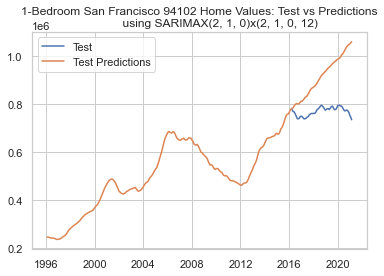

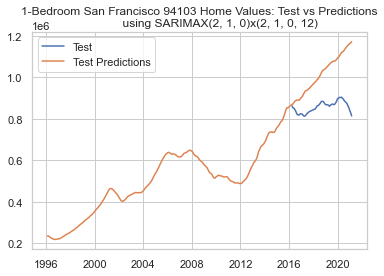

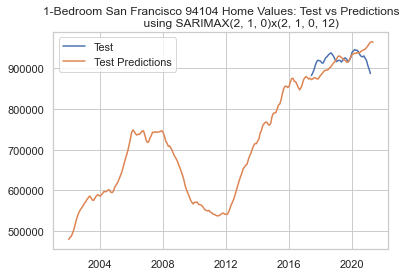

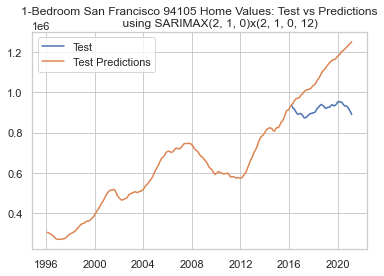

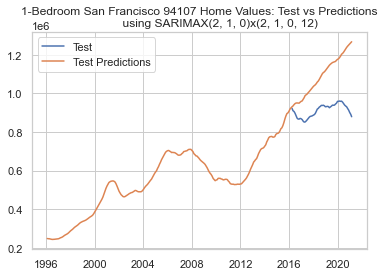

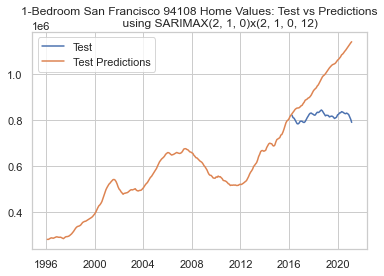

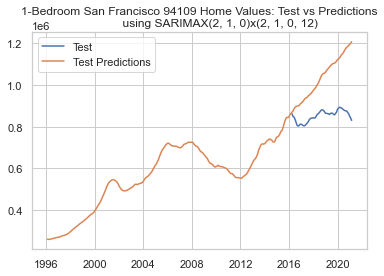

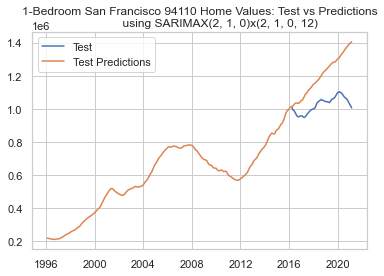

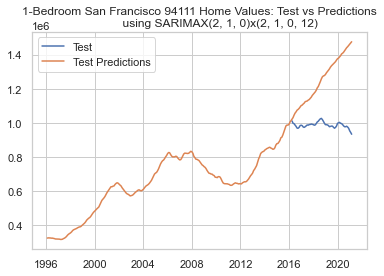

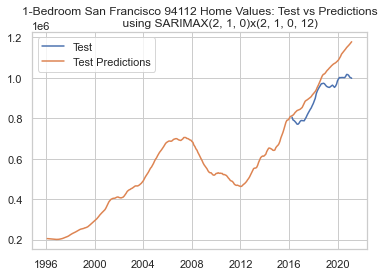

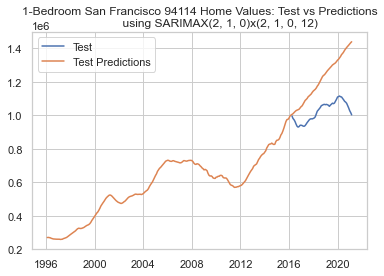

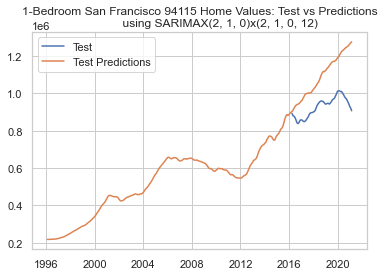

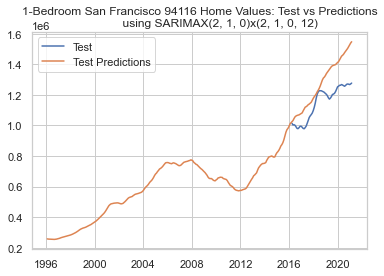

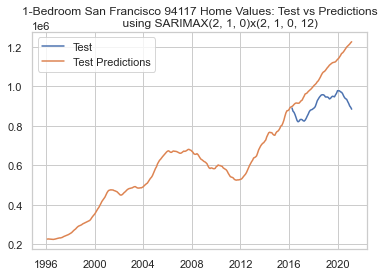

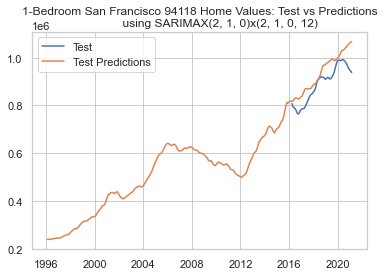

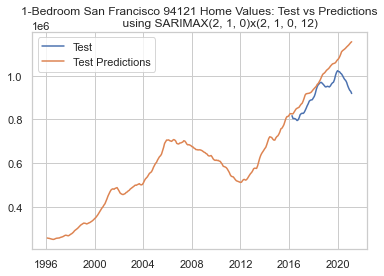

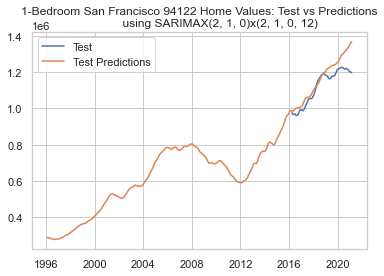

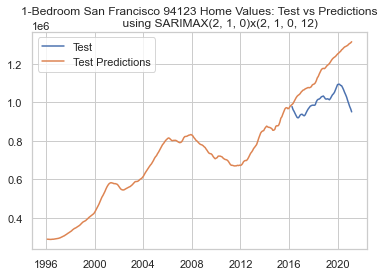

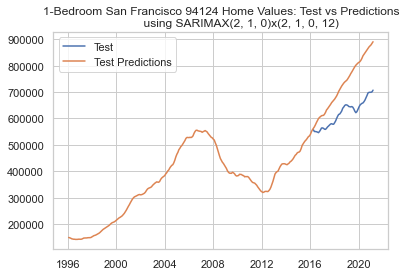

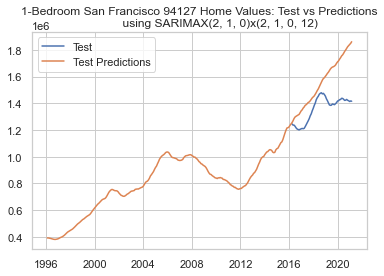

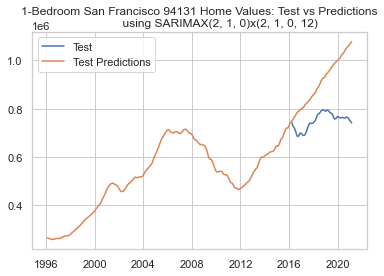

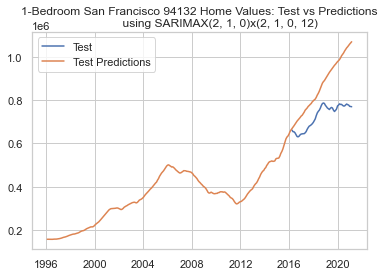

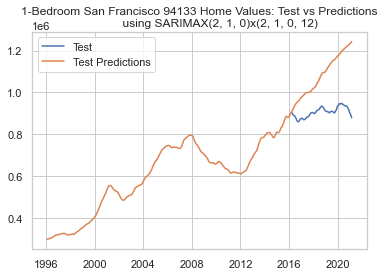

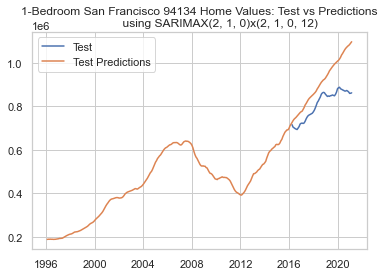

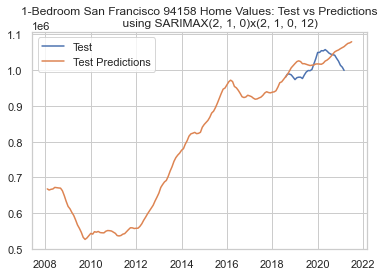

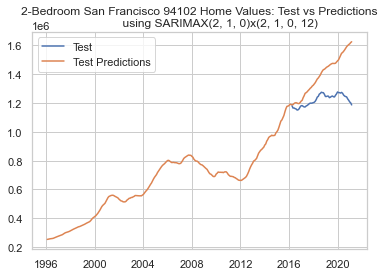

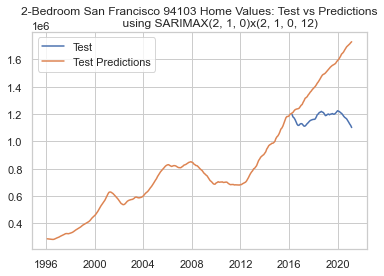

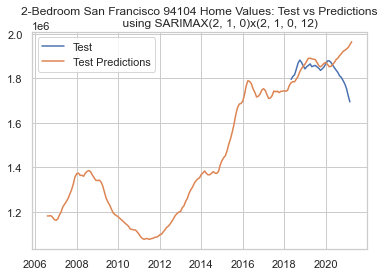

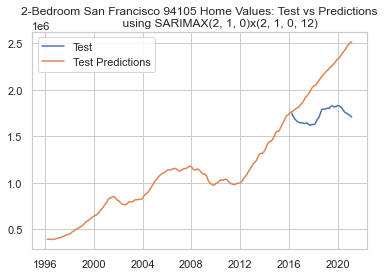

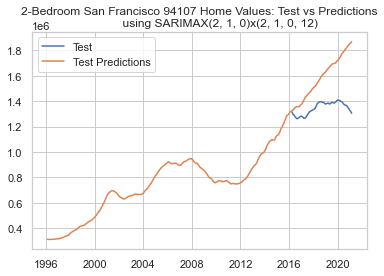

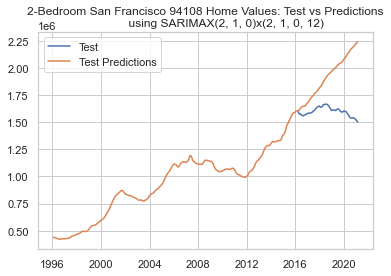

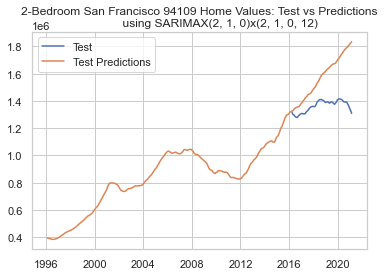

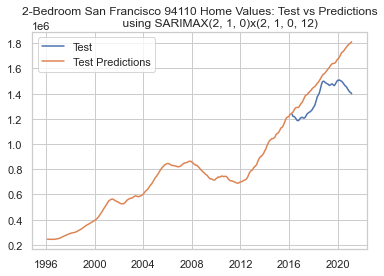

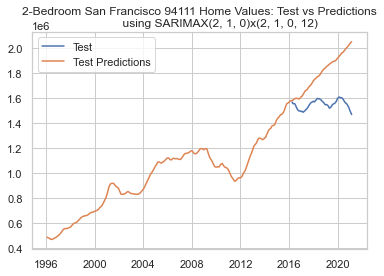

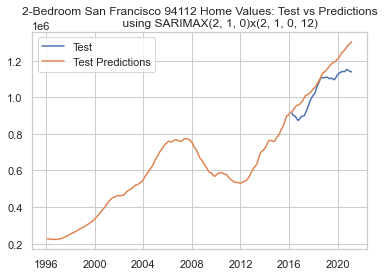

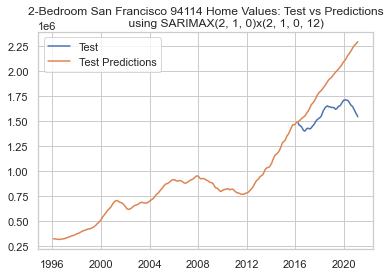

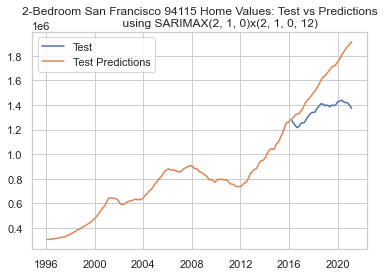

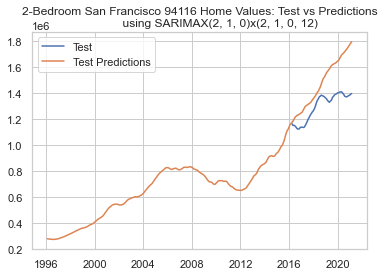

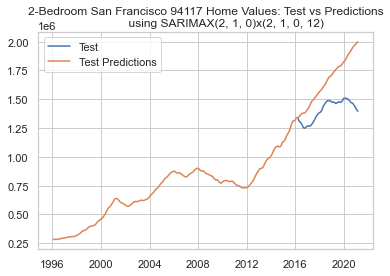

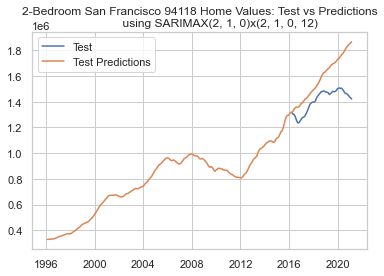

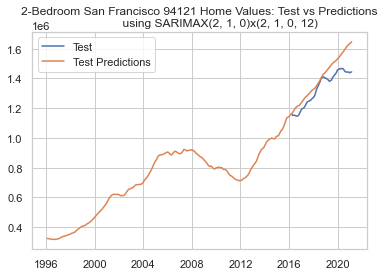

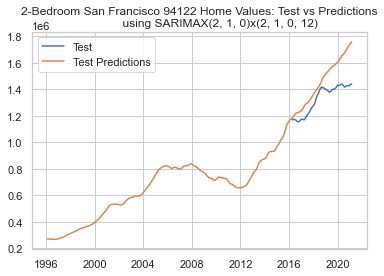

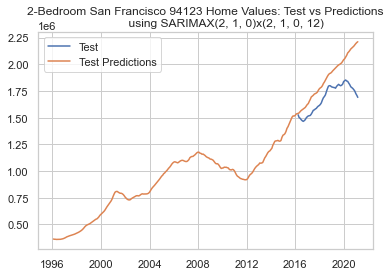

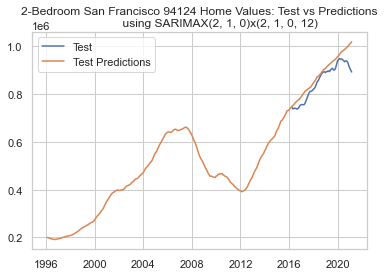

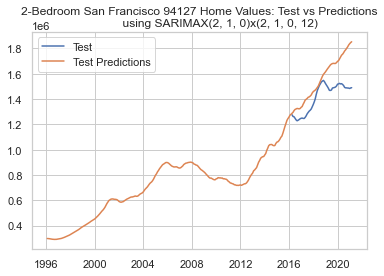

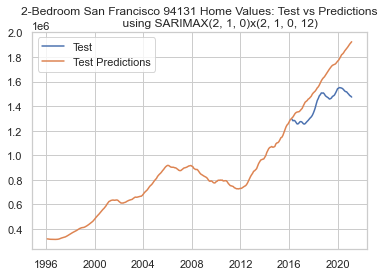

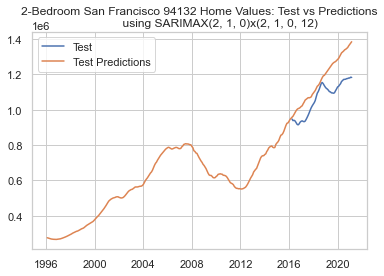

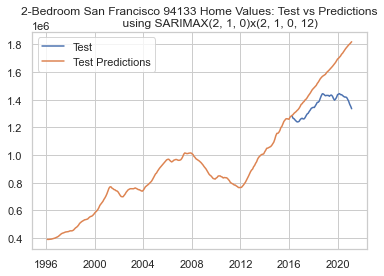

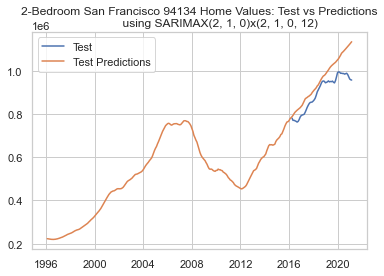

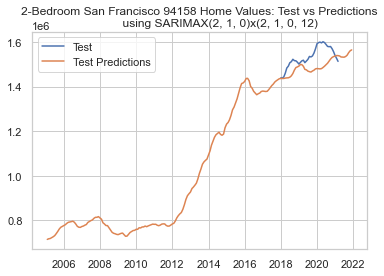

In [155]:
plot_train_test(sf_1_test_dict, sf_1_pred_dict, sf_1_best_df, 1)
plot_train_test(sf_2_test_dict, sf_2_pred_dict, sf_2_best_df, 2)

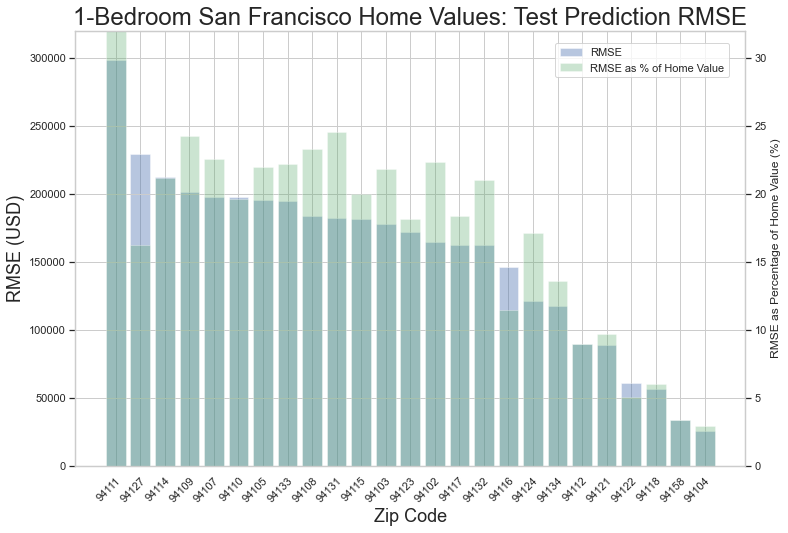

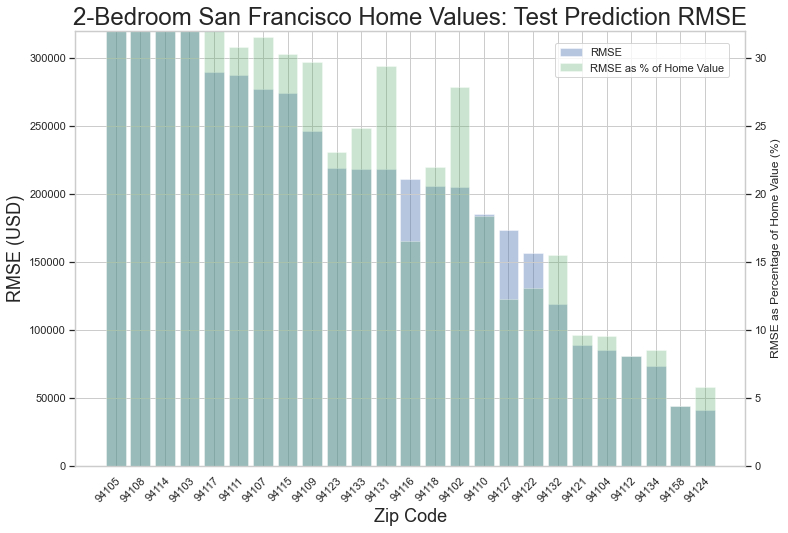

In [176]:
plot_RMSE(RMSE_1_df, 1)
plot_RMSE(RMSE_2_df, 2)

In [154]:
def plot_train_test(test_dict, predictions_dict, model_best_df, bedrooms):
    for zipcode, df in test_dict.items():
        fig, ax = plt.subplots()
        ax.plot(df.index, df.value, label='Test')
        ax.plot(predictions_dict[zipcode].index, predictions_dict[zipcode].value, label='Test Predictions')
        ax.set_title(
            f'{bedrooms}-Bedroom San Francisco {zipcode} Home Values: Test vs Predictions\n\
            using SARIMAX{model_best_df.loc[zipcode].param}x{model_best_df.loc[zipcode].param_seasonal}')
        plt.legend()
        plt.savefig(f'images/{bedrooms}_bdrm_test_predict{zipcode}.png')

In [177]:
def plot_RMSE(RMSE_df, bedrooms):
    fig, ax = plt.subplots(figsize = (12,8))
    ax.bar(x=RMSE_df.index, height=RMSE_df.RMSE, color = 'b', alpha=0.4, label = 'RMSE')
    ax.set_ylabel('RMSE (USD)', size = 18)
    ax.set_xlabel('Zip Code', size = 18)
    ax.set_ylim(0,3.2e5)
    ax1 = ax.twinx()
    ax1.bar(x=RMSE_df.index, height=RMSE_df.RMSE_vs_value, color = 'g', alpha=0.3, label = 'RMSE as % of Home Value')
    ax1.set_ylabel('RMSE as Percentage of Home Value (%)', size = 18)
    ax1.set_ylim(0,32)
    ax.set_title(f'{bedrooms}-Bedroom San Francisco Home Values: Test Prediction RMSE', size = 24)
    plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    fig.legend(bbox_to_anchor = (0.85, 0.86))
    plt.savefig(f'images/{bedrooms}_bdrm_RMSE.png')

In [ ]:
# RMSE_data = {'zipcode': zipcodes,
#              'RMSE': RMSE_list,
#              'last_value': hv
#             }
# RMSE_df = pd.DataFrame(RMSE_data)
# RMSE_df = RMSE_df.sort_values('RMSE', axis = 0, ascending=False)
# RMSE_df.set_index('zipcode', inplace=True)

# RMSE_df['RMSE_vs_value'] = 100*RMSE_df.RMSE/RMSE_df.last_value
# RMSE_df

In [ ]:
# plot_RMSE(RMSE_df, 1)
# sns.barplot(x=RMSE_df.index, height=RMSE_df.RMSE)

## Run Forecast

In [161]:
def run_forecast(data_dict, model_best_df):
    forecast_dict = {}

    for zipcode, df in data_dict.items():

        zipcode = zipcode[-5:]
        sari_mod = SARIMAX(df.dropna(),     
                           order=model_best_df.loc[zipcode].param,
                           seasonal_order=model_best_df.loc[zipcode].param_seasonal,
                           enforce_stationarity=False,
                           enforce_invertibility=False).fit()

        forecast = sari_mod.forecast(steps=12)
        forecast_dict[zipcode] = forecast
        fig, ax = plt.subplots()
        ax.plot(df.index, df.value, label='Historical')
        ax.plot(forecast, label='Forecast')
        ax.set_title(
            f'1-Bedroom San Francisco {zipcode} Home Values: 1 Year Forecast\n\
            using SARIMAX{model_best_df.loc[zipcode].param}x{model_best_df.loc[zipcode].param_seasonal}')
        plt.legend()
        plt.savefig(f'images/1_bdrm_forecast_{zipcode}.png')
    return forecast_dict

In [ ]:
sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df)
sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df)

In [ ]:
# sf_1_forecast_dict = {}

# for zipcode, df in sf_1_dict.items():

#     zipcode = zipcode[-5:]
#     sari_mod = SARIMAX(df.dropna(),     
#                        order=sf_1_best_df.loc[zipcode].param,
#                        seasonal_order=sf_1_best_df.loc[zipcode].param_seasonal,
#                        enforce_stationarity=False,
#                        enforce_invertibility=False).fit()
    
#     forecast = sari_mod.forecast(steps=12)
#     sf_1_forecast_dict[zipcode] = forecast
#     fig, ax = plt.subplots()
#     ax.plot(df.index, df.value, label='Historical')
#     ax.plot(forecast, label='Forecast')
#     ax.set_title(
#         f'1-Bedroom San Francisco {zipcode} Home Values: 1 Year Forecast\n\
#         using SARIMAX{sf_1_best_df.loc[zipcode].param}x{sf_1_best_df.loc[zipcode].param_seasonal}')
#     plt.legend()
#     plt.savefig(f'images/1_bdrm_forecast_{zipcode}.png')

In [ ]:
# sf_2_forecast_dict = {}

# for zipcode, df in sf_2_dict.items():

#     zipcode = zipcode[-5:]
#     sari_mod = SARIMAX(df.dropna(),     
#                        order=sf_2_best_df.loc[zipcode].param,
#                        seasonal_order=sf_2_best_df.loc[zipcode].param_seasonal,
#                        enforce_stationarity=False,
#                        enforce_invertibility=False).fit()
    
#     forecast = sari_mod.forecast(steps=12)
#     sf_2_forecast_dict[zipcode] = forecast
#     fig, ax = plt.subplots()
#     ax.plot(df.index, df.value, label='Historical')
#     ax.plot(forecast, label='Forecast')
#     ax.set_title(
#         f'2-Bedroom San Francisco {zipcode} Home Values: 1 Year Forecast\n\
#         using SARIMAX{sf_2_best_df.loc[zipcode].param}x{sf_2_best_df.loc[zipcode].param_seasonal}')
#     plt.legend()
#     plt.savefig(f'images/2_bdrm_forecast_{zipcode}.png')

# Results

In [ ]:
# sf_1_final_dict = {'zipcode': list(sf_1_forecast_dict.keys()) ,
#               'current_value': [df.iloc[-1].values[0] for df in list(sf_1_dict.values())],
#               'forecasted_value': [df.iloc[-1] for df in list(sf_1_forecast_dict.values())]
#              }
# sf_1_final_df = pd.DataFrame(sf_1_final_dict)

# sf_2_final_dict = {'zipcode': list(sf_2_forecast_dict.keys()) ,
#               'current_value': [df.iloc[-1].values[0] for df in list(sf_2_dict.values())],
#               'forecasted_value': [df.iloc[-1] for df in list(sf_2_forecast_dict.values())]
#              }
# sf_2_final_df = pd.DataFrame(sf_2_final_dict)

In [ ]:
# sf_1_final_df['percent_change'] = round(100*(sf_1_final_df.forecasted_value - sf_1_final_df.current_value )/sf_1_final_df.current_value,2)
# sf_2_final_df['percent_change'] = round(100*(sf_2_final_df.forecasted_value - sf_2_final_df.current_value )/sf_2_final_df.current_value,2)

In [ ]:
def create_final_df(data_dict, forecast_dict, bedrooms):
    final_dict = {'zipcode': list(forecast_dict.keys()),
                  'current_value': [df.iloc[-1].values[0] for df in list(data_dict.values())],
                  'forecasted_value': [df.iloc[-1] for df in list(forecast_dict.values())]
                  }
    final_df = pd.DataFrame(final_dict)
    final_df['percent_change'] = round(100*(final_df.forecasted_value - final_df.current_value )/final_df.current_value,2)
    final_sorted_df = final_df.sort_values('percent_change', axis = 0)
    final_sorted_df.set_index('zipcode', inplace=True)
    final_sorted_df.to_csv(f'data/{bedrooms}_bdrm_final_forecasts.csv')
    return final_sorted_df

In [ ]:
# sf_1_sorted_df = sf_1_final_df.sort_values('percent_change', axis = 0)
# sf_1_sorted_df.set_index('zipcode', inplace=True)
# # sf_1_sorted_df

In [ ]:
# sf_2_sorted_df = sf_2_final_df.sort_values('percent_change', axis = 0)
# sf_2_sorted_df.set_index('zipcode', inplace=True)
# # sf_2_sorted_df

In [ ]:
sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)

## Visualizations

In [187]:
def visualize_forecasts(df, df_all):
    # sns.set_palette('cubehelix', 1) 
    sns.set_theme(style="darkgrid")
    fig, ax = plt.subplots(figsize=(20,12))
    ax.set_title(f'{bedroom}-Bedroom Home Values in San Franciso by Zip Code: Forecast', size=24)
    sns.lineplot(data=df, x=df.date, y=df.value, ax=ax, hue='zipcode', style='zipcode', label = 'Historical')
    sns.lineplot(data=df_all, x=df_all.index, y=df_all.value, ax=ax, color = 'b', label='all')
    ax.set_xlabel('Year',  size=20)
    ax.set_ylabel('Home Value (USD)', size=20)
    ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.set_yticks(np.linspace(1e5,1.5e6,15))
    ax.set_ylim((1e5, 1.5e6))
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.savefig('images/1_bdrm_home_values.png')

In [178]:
def visualize_results(df1, df2):
    fig, ax = plt.subplots(2, 1, figsize = (12,16))
    ax[0].bar(x=df1.index, height=df1.percent_change, color = 'slateblue', alpha = 0.9)
    ax[0].set_title('Percent Change of 1-Bedroom Home Values in San Francisco', size=24)
    ax[0].set_xlabel('Zip Code', size=18)
    ax[0].set_ylabel('Percent Change after 1 Year (%)', size=18)
    # ax[1].bar(x=sf_1_sorted_df.index, height=sf_2_sorted_df.loc[sf_1_sorted_df.index].percent_change)
    ax[1].bar(x=df2.index, height=df2.percent_change, color = 'royalblue', alpha = 0.8)
    ax[1].set_title('Percent Change of 2-Bedroom Home Values in San Francisco', size=24)
    ax[1].set_xlabel('Zip Code', size=18)
    ax[1].set_ylabel('Percent Change after 1 Year (%)', size=18)
    plt.setp(ax[0].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    plt.setp(ax[1].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
    fig.tight_layout(pad=2.0)
    plt.savefig(f'images/final_forecasts.png')

In [ ]:
def best_3_zipcodes(sorted_df, bedroomoms):
    print(f'The zipcodes with the greatest projected growth in mid-tier {bedroom}-bedroom home values are {sorted_df.iloc[-3]},\
        {sorted_df.iloc[-2]}, and {sorted_df.iloc[-1]}.')

In [ ]:
# 1 diff
# visualize_forecasts(sf_1_sorted_df, sf_2_sorted_df)
visualize_resultss(sf_1_sorted_df, sf_2_sorted_df

In [ ]:
best_3_zipcodes(sf_1_sorted_df, 1)
best_3_zipcodes(sf_2_sorted_df, 2)

In [ ]:
# fig, ax = plt.subplots(2, 1, figsize = (12,16))
# ax[0].bar(x=sf_1_sorted_df.index, height=sf_1_sorted_df.percent_change)
# ax[0].set_title('Percent Change of 1-Bedroom Home Values in San Francisco', size=24)
# ax[0].set_xlabel('Zip Code', size=18)
# ax[0].set_ylabel('Percent Change after 1 Year (%)', size=18)
# # ax[1].bar(x=sf_1_sorted_df.index, height=sf_2_sorted_df.loc[sf_1_sorted_df.index].percent_change)
# ax[1].bar(x=sf_2_sorted_df.index, height=sf_2_sorted_df.percent_change)
# ax[1].set_title('Percent Change of 2-Bedroom Home Values in San Francisco', size=24)
# ax[1].set_xlabel('Zip Code', size=18)
# ax[1].set_ylabel('Percent Change after 1 Year (%)', size=18)
# plt.setp(ax[0].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# plt.setp(ax[1].xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# fig.tight_layout(pad=2.0)
# plt.savefig('images/final_forecasts.png')

# Other Params

In [ ]:
# sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict)
# sf_1_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict)
# zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict, 12, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2)
# zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_2_train_dict, 12, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2)
# sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
# sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)
# sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df)
# sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df)
# sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
# sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)
# visualize_forecasts(sf_1_sorted_df, sf_2_sorted_df)